In [1]:
import os, sys
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
from asteroid.metrics import get_metrics
from pprint import pprint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.cuda.empty_cache()

# Get the pretrained models
print("Pre-trained models available:")
for model_name in os.listdir('../../pretrained_models'):
    print(model_name)
    
def normalize_tensor_wav(wav_tensor, eps=1e-8, std=None):
    mean = wav_tensor.mean(-1, keepdim=True)
    if std is None:
        std = wav_tensor.std(-1, keepdim=True)
    return (wav_tensor - mean) / (std + eps)
    
anechoic_model_p = '../../pretrained_models/GroupCom_Sudormrf_U8_Bases512_WSJ02mix.pt'
anechoic_model_p = '../../pretrained_models/Improved_Sudormrf_U16_Bases512_WSJ02mix.pt'
anechoic_model_p = '../../pretrained_models/Improved_Sudormrf_U36_Bases2048_WSJ02mix.pt'
noisy_reverberant_model_p = '../../pretrained_models/Improved_Sudormrf_U16_Bases2048_WHAMRexclmark.pt'
noisy_reverberant_model_p = '../../pretrained_models/Improved_Sudormrf_U36_Bases4096_WHAMRexclmark.pt'

# Load the appropriate class modules
sys.path.append("../../")
import sudo_rm_rf.dnn.experiments.utils.mixture_consistency as mixture_consistency
import sudo_rm_rf.dnn.models.improved_sudormrf as improved_sudormrf
import sudo_rm_rf.dnn.models.groupcomm_sudormrf_v2 as sudormrf_gc_v2

Pre-trained models available:
Improved_Sudormrf_U16_Bases2048_WHAMRexclmark.pt
GroupCom_Sudormrf_U8_Bases512_WSJ02mix.pt
Improved_Sudormrf_U16_Bases512_WSJ02mix.pt
Improved_Sudormrf_U36_Bases4096_WHAMRexclmark.pt
Improved_Sudormrf_U36_Bases2048_WSJ02mix.pt
.gitattributes
download_pretrained_models.sh


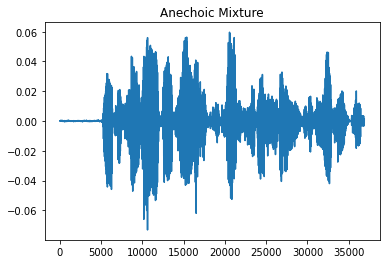

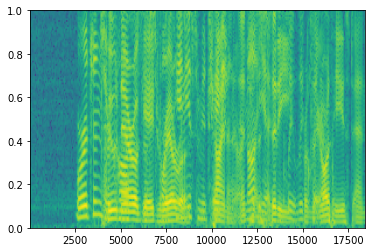

In [14]:
whamr_test_folder_path = '/mnt/data/whamr/wav8k/min/tt'
# wav_path = 'point to a random mixture file of a mixture of 2 speakers'
chosen_file = '447o030x_0.03457_441c0209_-0.03457.wav'
chosen_file = '446o030h_0.13806_444c020w_-0.13806.wav'
chosen_file = '052a0507_1.6424_422a0109_-1.6424.wav'
# chosen_file = np.random.choice(os.listdir(os.path.join(whamr_test_folder_path, 'mix_clean_anechoic')))

wav_path = os.path.join(whamr_test_folder_path, 'mix_clean_anechoic', chosen_file)

ground_truth_sources = torch.tensor(np.array([
    torchaudio.load(os.path.join(whamr_test_folder_path,
                                 's1_anechoic', chosen_file))[0].detach().numpy()[0],
    torchaudio.load(os.path.join(whamr_test_folder_path,
                                 's2_anechoic', chosen_file))[0].detach().numpy()[0]
]))

anechoic_sampled_mixture, _ = torchaudio.load(wav_path)

waveform = anechoic_sampled_mixture.detach().numpy()[0]
plt.plot(waveform)
plt.title("Anechoic Mixture")
plt.show()
plt.close()
plt.specgram(waveform)

ipd.display(ipd.Audio(waveform, rate=8000))

### Just load a pre-trained model and apply it!

In [15]:
# Load a pretrained model
anechoic_separation_model = torch.load(anechoic_model_p)

# Normalize the waveform and apply the model
input_mix_std = anechoic_sampled_mixture.std(-1, keepdim=True)
input_mix_mean = anechoic_sampled_mixture.mean(-1, keepdim=True)
input_mix = (anechoic_sampled_mixture - input_mix_mean) / (input_mix_std + 1e-9)

# Apply the model
with torch.no_grad():
    rec_sources_wavs = anechoic_separation_model(input_mix.unsqueeze(1))

# # In case you are using the pre-trained models with Group communication
# # please also use the mixture consistency right after the estimated waveforms
if "GroupCom" in anechoic_model_p:
    rec_sources_wavs = mixture_consistency.apply(rec_sources_wavs, input_mix.unsqueeze(1))

# Rescale the input sources with the mixture mean and variance
rec_sources_wavs = (rec_sources_wavs * input_mix_std) + input_mix_mean
# It is that simple!

In [16]:
# We can also find the appropriate order of the sources
import asteroid
pairwise_negsisdr_func = asteroid.losses.PairwiseNegSDR("sisdr")
sisdrs = -pairwise_negsisdr_func(rec_sources_wavs, ground_truth_sources.unsqueeze(0))
if sisdrs[0, 0, 0] + sisdrs[0, 1, 1] < sisdrs[0, 1, 0] + sisdrs[0, 0, 1]:
    rec_sources_wavs = torch.flip(rec_sources_wavs, [1])
    print("Changed the order of sources for best allignment")

Changed the order of sources for best allignment


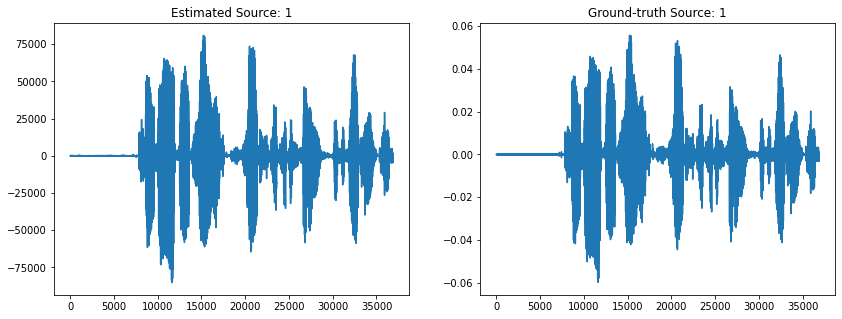

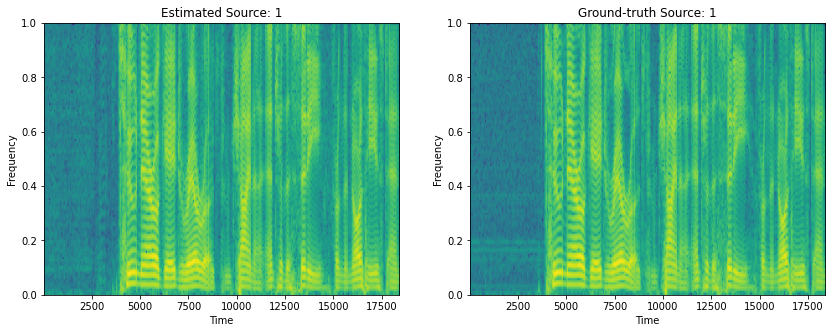

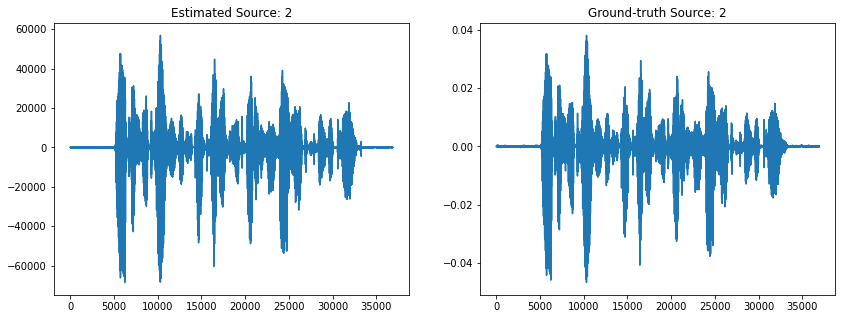

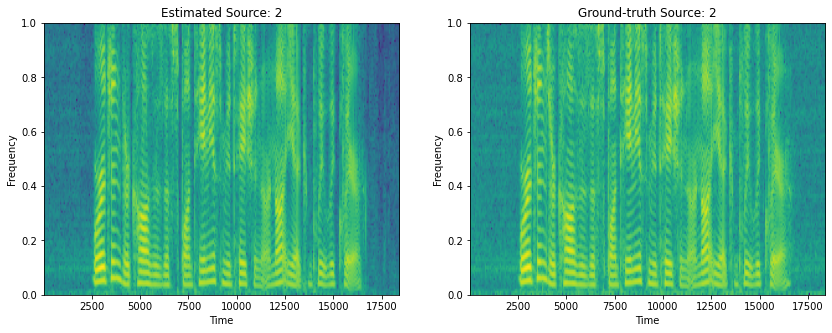

{'input_pesq': 1.598179280757904,
 'input_sar': 109.64325055847871,
 'input_sdr': 0.18530059415126598,
 'input_si_sdr': 0.027337074279785156,
 'input_sir': 0.18530059426344914,
 'input_stoi': 0.7115502173709112,
 'pesq': 3.8449647426605225,
 'sar': 19.373749718659315,
 'sdr': 19.051246024661875,
 'si_sdr': 18.776787757873535,
 'sir': 30.69899641774542,
 'stoi': 0.9816561475545238}


In [17]:
# Plot the separated waveforms and their corresponding metrics 
for src_idx in range(rec_sources_wavs.shape[1]):
    est_waveform = rec_sources_wavs[0, src_idx].detach().numpy()
    gt_waveform = ground_truth_sources[src_idx].detach().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].plot(est_waveform)
    ax[1].plot(gt_waveform)
    ax[0].set_title(f"Estimated Source: {src_idx + 1}")
    ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
    plt.show()
    plt.close()
    
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].specgram(est_waveform)
    ax[1].specgram(gt_waveform)
    ax[0].set_title(f"Estimated Source: {src_idx + 1}")
    ax[0].set_ylabel(f"Frequency")
    ax[0].set_xlabel(f"Time")
    ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
    ax[1].set_ylabel(f"Frequency")
    ax[1].set_xlabel(f"Time")
    plt.show()
    plt.close()
    
    ipd.display(ipd.Audio(est_waveform, rate=8000))
    ipd.display(ipd.Audio(gt_waveform, rate=8000))

metrics_dict = get_metrics(input_mix[0].detach().numpy(),
                           normalize_tensor_wav(ground_truth_sources).detach().numpy(),
                           normalize_tensor_wav(rec_sources_wavs[0]).detach().numpy(),
                           compute_permutation=True, sample_rate=8000, metrics_list='all')
pprint(metrics_dict)

## Wait... that means that we can Sudo rm -rf also reverberant and noisy sources?

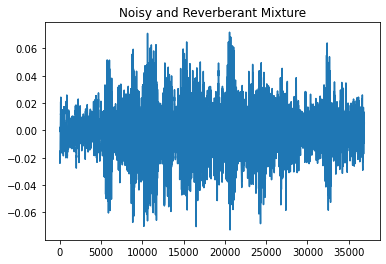

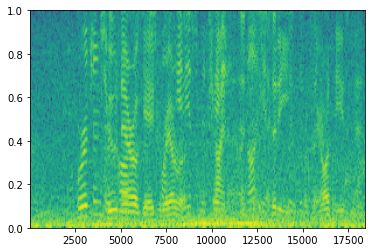

In [18]:
wav_path = os.path.join(whamr_test_folder_path, 'mix_both_reverb', chosen_file)
noisy_reverberant_sampled_mixture, _ = torchaudio.load(wav_path)

waveform = noisy_reverberant_sampled_mixture.detach().numpy()[0]
plt.plot(waveform)
plt.title("Noisy and Reverberant Mixture")
plt.show()
plt.close()
plt.specgram(waveform)


ipd.display(ipd.Audio(waveform, rate=8000))


### Of course we can Sudo rm-rf anything!

In [19]:
noisy_and_reverberant_separation_model = torch.load(noisy_reverberant_model_p)

# Normalize the waveform and apply the model
input_mix_std = noisy_reverberant_sampled_mixture.std(-1, keepdim=True)
input_mix_mean = noisy_reverberant_sampled_mixture.mean(-1, keepdim=True)
input_mix = (noisy_reverberant_sampled_mixture - input_mix_mean) / (input_mix_std + 1e-9)

# Apply the model
with torch.no_grad():
    rec_sources_wavs = noisy_and_reverberant_separation_model(input_mix.unsqueeze(1))

# # In case you are using the pre-trained models with Group communication
# # please also use the mixture consistency right after the estimated waveforms
# import sudo_rm_rf.dnn.experiments.utils.mixture_consistency as mixture_consistency
# rec_sources_wavs = mixture_consistency.apply(rec_sources_wavs, input_mix.unsqueeze(1))

# Rescale the input sources with the mixture mean and variance
rec_sources_wavs = (rec_sources_wavs * input_mix_std) + input_mix_mean

In [20]:
# We can also find the appropriate order of the sources
import asteroid
pairwise_negsisdr_func = asteroid.losses.PairwiseNegSDR("sisdr")
sisdrs = -pairwise_negsisdr_func(rec_sources_wavs, ground_truth_sources.unsqueeze(0))
if sisdrs[0, 0, 0] + sisdrs[0, 1, 1] < sisdrs[0, 1, 0] + sisdrs[0, 0, 1]:
    rec_sources_wavs = torch.flip(rec_sources_wavs, [1])
    print("Changed the order of sources for best allignment")

tensor([[[-34.8086,   9.4880],
         [ 11.1272, -34.5339]]])
Changed the order of sources for best allignment


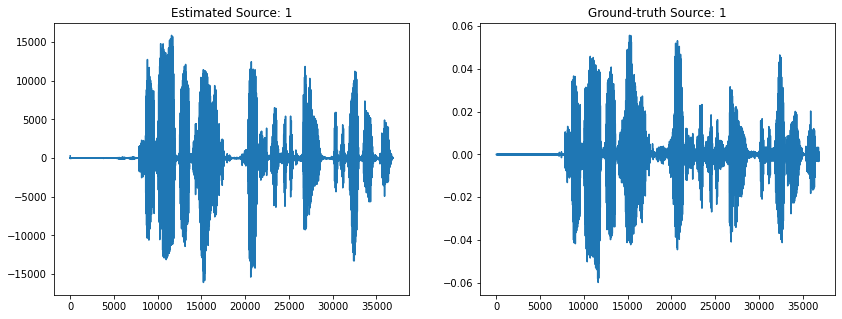

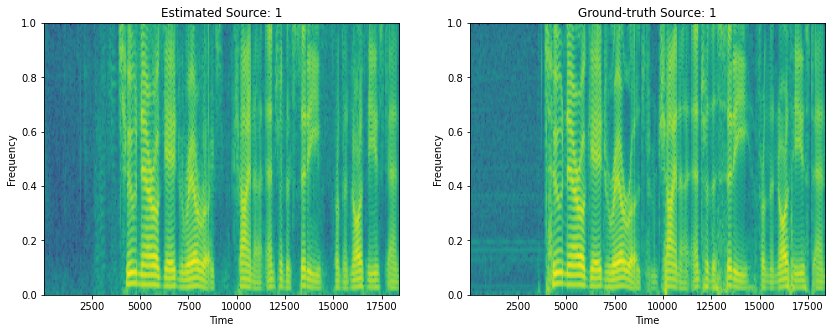

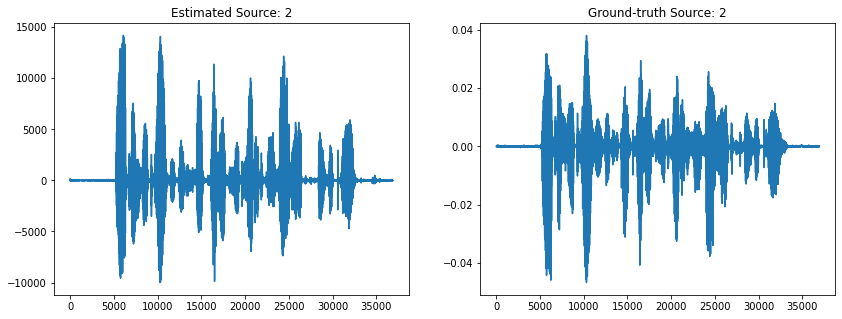

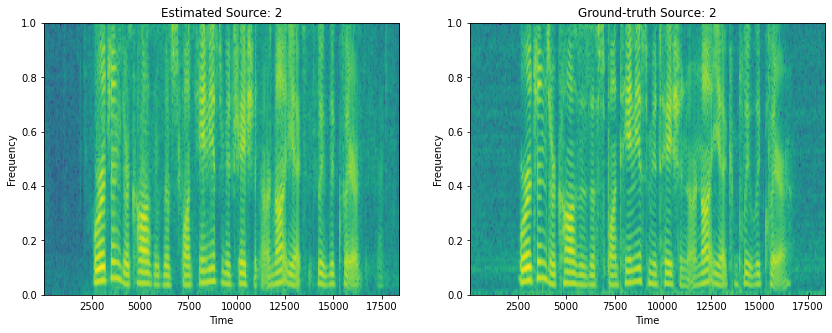

{'input_pesq': 1.4193698167800903,
 'input_sar': -1.3608647685384845,
 'input_sdr': -5.876739169960889,
 'input_si_sdr': -6.499982833862305,
 'input_sir': 0.20435230837259377,
 'input_stoi': 0.6190809291977672,
 'pesq': 2.4843146800994873,
 'sar': 11.920024495866981,
 'sdr': 11.72488677820171,
 'si_sdr': 10.307599067687988,
 'sir': 25.703990610543315,
 'stoi': 0.9090751525946521}


In [21]:
# Plot the separated waveforms and their corresponding metrics 
for src_idx in range(rec_sources_wavs.shape[1]):
    est_waveform = rec_sources_wavs[0, src_idx].detach().numpy()
    gt_waveform = ground_truth_sources[src_idx].detach().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].plot(est_waveform)
    ax[1].plot(gt_waveform)
    ax[0].set_title(f"Estimated Source: {src_idx + 1}")
    ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
    plt.show()
    plt.close()
    
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].specgram(est_waveform)
    ax[1].specgram(gt_waveform)
    ax[0].set_title(f"Estimated Source: {src_idx + 1}")
    ax[0].set_ylabel(f"Frequency")
    ax[0].set_xlabel(f"Time")
    ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
    ax[1].set_ylabel(f"Frequency")
    ax[1].set_xlabel(f"Time")
    plt.show()
    plt.close()
    
    ipd.display(ipd.Audio(est_waveform, rate=8000))
    ipd.display(ipd.Audio(gt_waveform, rate=8000))

metrics_dict = get_metrics(input_mix[0].detach().numpy(),
                           normalize_tensor_wav(ground_truth_sources).detach().numpy(),
                           normalize_tensor_wav(rec_sources_wavs[0]).detach().numpy(),
                           compute_permutation=True, sample_rate=8000, metrics_list='all')
pprint(metrics_dict)

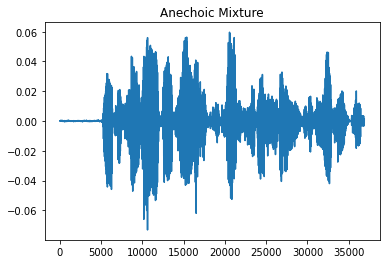

GroupCom_Sudormrf_U8_Bases512_WSJ02mix.pt


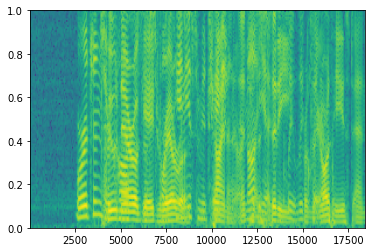

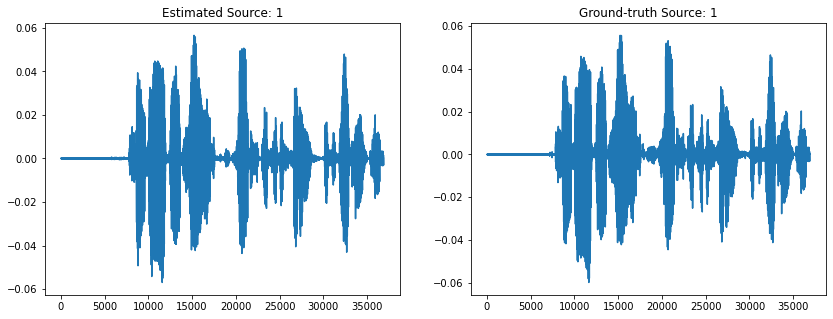

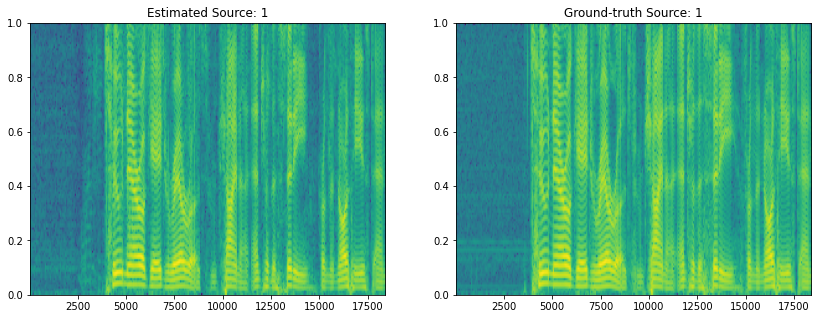

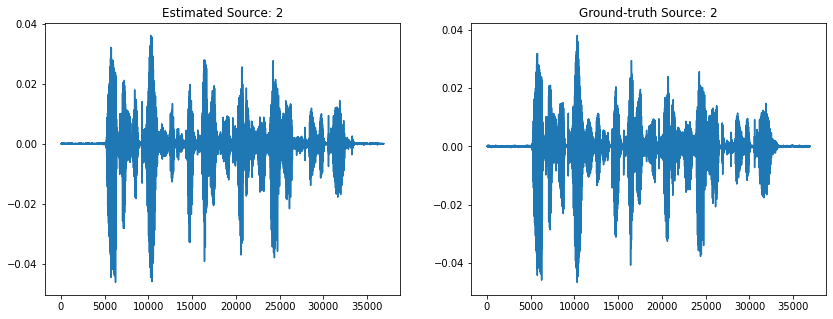

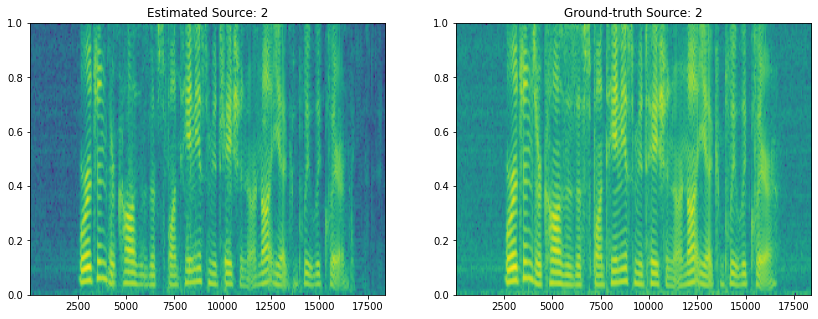

{'input_pesq': 1.598179280757904,
 'input_sar': 109.64325055847871,
 'input_sdr': 0.18530059415126598,
 'input_si_sdr': 0.027337074279785156,
 'input_sir': 0.18530059426344914,
 'input_stoi': 0.7115502173709112,
 'pesq': 3.1130380630493164,
 'sar': 14.907649190272634,
 'sdr': 14.439758415059226,
 'si_sdr': 14.106304168701172,
 'sir': 24.506298504187836,
 'stoi': 0.9521791683477034}
Improved_Sudormrf_U16_Bases512_WSJ02mix.pt


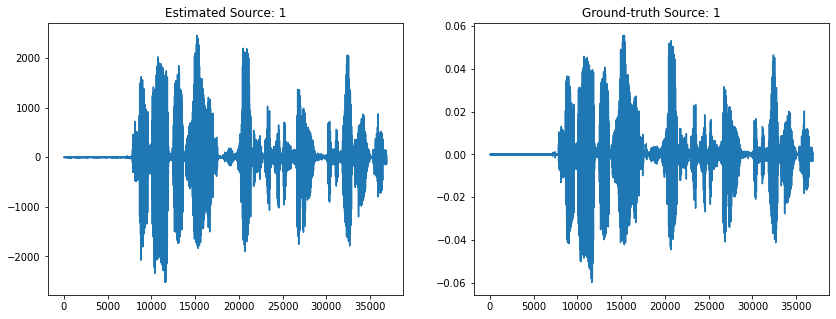

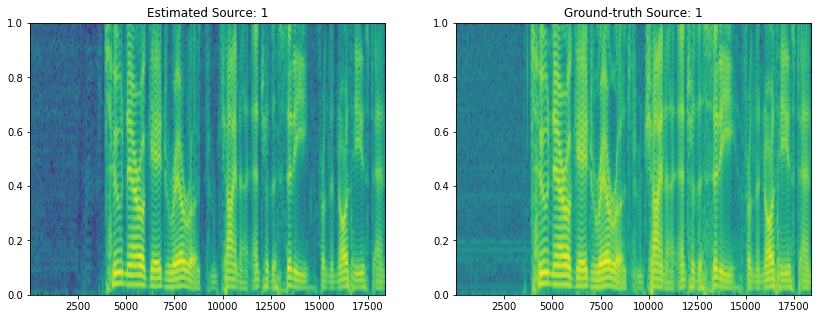

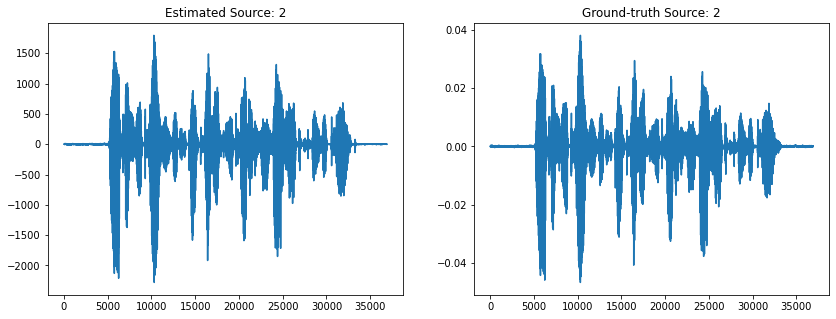

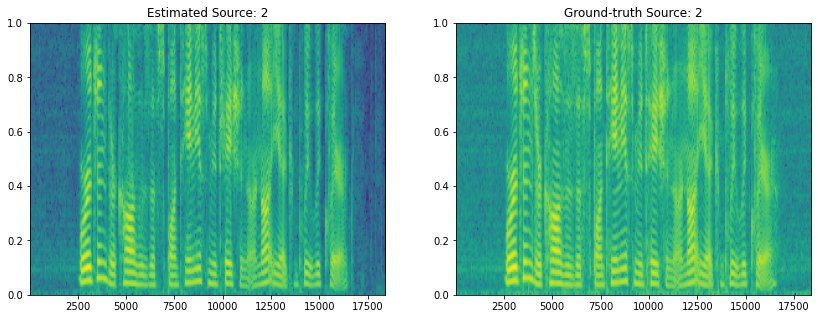

{'input_pesq': 1.598179280757904,
 'input_sar': 109.64325055847871,
 'input_sdr': 0.18530059415126598,
 'input_si_sdr': 0.027337074279785156,
 'input_sir': 0.18530059426344914,
 'input_stoi': 0.7115502173709112,
 'pesq': 3.4865152835845947,
 'sar': 17.548020030778694,
 'sdr': 17.183874702349172,
 'si_sdr': 16.901577472686768,
 'sir': 28.22364435669091,
 'stoi': 0.9725729788237407}
Improved_Sudormrf_U36_Bases2048_WSJ02mix.pt
Changed the order of sources for best allignment


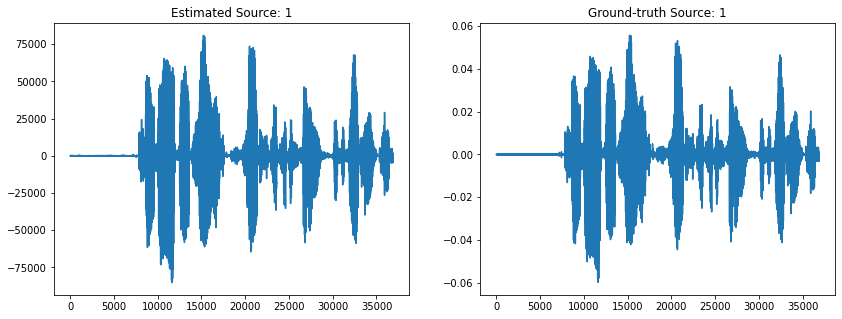

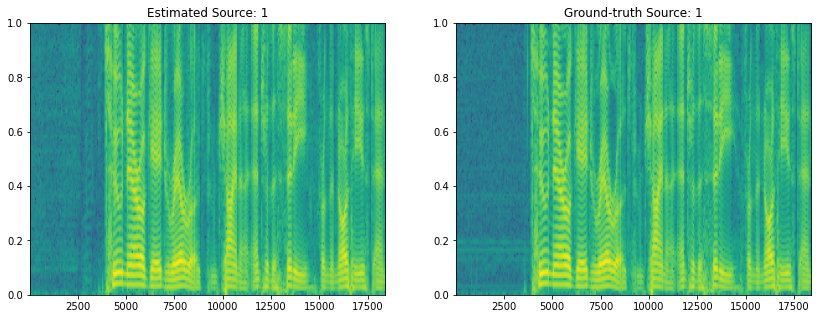

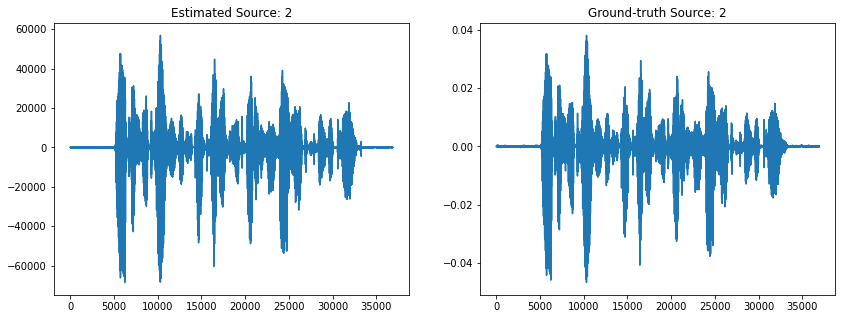

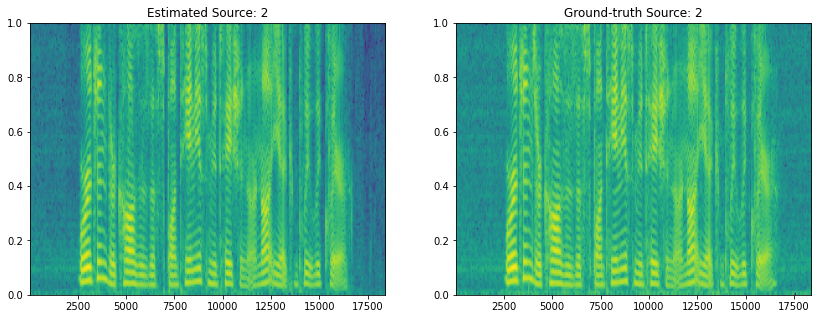

{'input_pesq': 1.598179280757904,
 'input_sar': 109.64325055847871,
 'input_sdr': 0.18530059415126598,
 'input_si_sdr': 0.027337074279785156,
 'input_sir': 0.18530059426344914,
 'input_stoi': 0.7115502173709112,
 'pesq': 3.8449647426605225,
 'sar': 19.373749718659315,
 'sdr': 19.051246024661875,
 'si_sdr': 18.776787757873535,
 'sir': 30.69899641774542,
 'stoi': 0.9816561475545238}


In [13]:
# Just to understand the difference, play the output of a few different models
all_anechoic_models_paths = [
    '../../pretrained_models/GroupCom_Sudormrf_U8_Bases512_WSJ02mix.pt',
    '../../pretrained_models/Improved_Sudormrf_U16_Bases512_WSJ02mix.pt',
    '../../pretrained_models/Improved_Sudormrf_U36_Bases2048_WSJ02mix.pt']


chosen_file = '447o030x_0.03457_441c0209_-0.03457.wav'
chosen_file = '446o030h_0.13806_444c020w_-0.13806.wav'
chosen_file = '052a0507_1.6424_422a0109_-1.6424.wav'
# chosen_file = np.random.choice(os.listdir(os.path.join(whamr_test_folder_path, 'mix_clean_anechoic')))

wav_path = os.path.join(whamr_test_folder_path, 'mix_clean_anechoic', chosen_file)

ground_truth_sources = torch.tensor(np.array([
    torchaudio.load(os.path.join(whamr_test_folder_path,
                                 's1_anechoic', chosen_file))[0].detach().numpy()[0],
    torchaudio.load(os.path.join(whamr_test_folder_path,
                                 's2_anechoic', chosen_file))[0].detach().numpy()[0]
]))

anechoic_sampled_mixture, _ = torchaudio.load(wav_path)

waveform = anechoic_sampled_mixture.detach().numpy()[0]
plt.plot(waveform)
plt.title("Anechoic Mixture")
plt.show()
plt.close()
plt.specgram(waveform)

ipd.display(ipd.Audio(waveform, rate=8000))

for anechoic_model_p in all_anechoic_models_paths:
    model_name = os.path.basename(anechoic_model_p)
    print(model_name)
    
    # Load a pretrained model
    anechoic_separation_model = torch.load(anechoic_model_p)

    # Normalize the waveform and apply the model
    input_mix_std = anechoic_sampled_mixture.std(-1, keepdim=True)
    input_mix_mean = anechoic_sampled_mixture.mean(-1, keepdim=True)
    input_mix = (anechoic_sampled_mixture - input_mix_mean) / (input_mix_std + 1e-9)

    # Apply the model
    with torch.no_grad():
        rec_sources_wavs = anechoic_separation_model(input_mix.unsqueeze(1))

        # # In case you are using the pre-trained models with Group communication
        # # please also use the mixture consistency right after the estimated waveforms
        if "GroupCom" in model_name:
            rec_sources_wavs = mixture_consistency.apply(rec_sources_wavs, input_mix.unsqueeze(1))

        # Rescale the input sources with the mixture mean and variance
        rec_sources_wavs = (rec_sources_wavs * input_mix_std) + input_mix_mean
    
    pairwise_negsisdr_func = asteroid.losses.PairwiseNegSDR("sisdr")
    sisdrs = -pairwise_negsisdr_func(rec_sources_wavs, ground_truth_sources.unsqueeze(0))
    if sisdrs[0, 0, 0] + sisdrs[0, 1, 1] < sisdrs[0, 1, 0] + sisdrs[0, 0, 1]:
        rec_sources_wavs = torch.flip(rec_sources_wavs, [1])
        print("Changed the order of sources for best allignment")
    
    
    for src_idx in range(rec_sources_wavs.shape[1]):
        est_waveform = rec_sources_wavs[0, src_idx].detach().numpy()
        gt_waveform = ground_truth_sources[src_idx].detach().numpy()
        fig, ax = plt.subplots(1, 2, figsize=(14,5))
        ax[0].plot(est_waveform)
        ax[1].plot(gt_waveform)
        ax[0].set_title(f"Estimated Source: {src_idx + 1}")
        ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
        plt.show()
        plt.close()

        fig, ax = plt.subplots(1, 2, figsize=(14,5))
        ax[0].specgram(est_waveform)
        ax[1].specgram(gt_waveform)
        ax[0].set_title(f"Estimated Source: {src_idx + 1}")
        ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
        plt.show()
        plt.close()

        ipd.display(ipd.Audio(est_waveform, rate=8000))
        ipd.display(ipd.Audio(gt_waveform, rate=8000))

    metrics_dict = get_metrics(input_mix[0].detach().numpy(),
                               normalize_tensor_wav(ground_truth_sources).detach().numpy(),
                               normalize_tensor_wav(rec_sources_wavs[0]).detach().numpy(),
                               compute_permutation=True, sample_rate=8000, metrics_list='all')
    pprint(metrics_dict)
    